## Comparing Classification Models - You're Probably Doing It Wrong

This notebook demonstrates the use of statistical tests to compare multiple machine learning models on a classification task. Rather than focusing on tests like 5X10-fold cross-validation or McNemar's test, which are discussed in this [post](http://practicalcheminformatics.blogspot.com/2020/05/some-thoughts-on-comparing.html), we'll focus on determining whether there is a statistically significant difference between methods when considering distributions of metrics across multiple cross-validation folds.

### Installation
<pre>pip install pandas pengouin seaborn matplotlib sklearn</pre>
We need the development version of scikit-posthocs to get critical difference diagrams
<pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef

A few utility functions to make life easier 

In [2]:
def calc_classification_metrics(df_in, cycle_col, val_col, prob_col, pred_col):
    """
    Calculate classification metrics (ROC AUC, PR AUC, MCC)
    :param df_in: input dataframe must contain columns [method, split] as well the columns specified in the arguments
    :param cycle_col: column indicating the cross-validation fold
    :param val_col: column with the group truth value
    :param prob_col: column with probability (e.g. from sklearn predict_proba)
    :param pred_col: column with binary predictions (e.g. from sklearn predict)
    :return: a dataframe with [cv_cycle, method, split, roc_auc, pr_auc, mcc]
    """
    metric_list = []
    for k, v in df_in.groupby([cycle_col, "method", "split"]):
        cycle, method, split = k
        roc_auc = roc_auc_score(v[val_col], v[prob_col])
        pr_auc = average_precision_score(v[val_col], v[prob_col])
        mcc = matthews_corrcoef(v[val_col], v[pred_col])
        metric_list.append([cycle, method, split, roc_auc, pr_auc, mcc])
    metric_df = pd.DataFrame(metric_list, columns=["cv_cycle", "method", "split", "roc_auc", "pr_auc", "mcc"])
    return metric_df


def make_barplots(df, show_errorbars=True):
    """
    Plot barplots for [roc_auc, pr_auc, mcc] with error bars, an example how NOT to compare methods
    :param df: input dataframe, must contain [method, roc_auc, pr_auc, mcc]
    """
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    
    errorbar = None
    if show_errorbars:
        errorbar = "sd"

    figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 8))
    for i, stat in enumerate(["roc_auc", "pr_auc", "mcc"]):
        ax = sns.barplot(x="method", y=stat, ax=axes[i], data=df, capsize=0.25, errorbar=errorbar)
        title = stat.replace("_", " ").upper()
        ax.set_xlabel("")
        ax.set_ylabel(title)
        ax.set_ylim(0, 1)
    plt.tight_layout()


def make_boxplots(df):
    """
    Plot box plots showing comparisons of [roc_auc, pr_auc, mcc], p-value for Friedman's test is shown as the plot title
    :param df: input dataframe, must contain [cv_cycle, method, roc_auc, pr_auc, mcc]
    """
    sns.set_context('notebook')
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    sns.set_style('whitegrid')
    figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 8))

    for i, stat in enumerate(["roc_auc", "pr_auc", "mcc"]):
        friedman = pg.friedman(df, dv=stat, within="method", subject="cv_cycle")['p-unc'].values[0]
        ax = sns.boxplot(y=stat, x="method", ax=axes[i], data=df)
        title = stat.replace("_", " ").upper()
        ax.set_title(f"p={friedman:.03f}")
        ax.set_xlabel("")
        ax.set_ylabel(title)
        ax.set_ylim(0, 1)
    plt.tight_layout()


def make_sign_plots(df):
    """
    Plot sign plots showing statistical significance of comparisons of [roc_auc, pr_auc, mcc]
    :param df: input dataframe, must contain [method, cv_cycle, roc_auc, pr_auc, mcc]
    """
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
    sns.set(rc={'figure.figsize': (4, 3)}, font_scale=1.5)
    figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 8))

    for i, stat in enumerate(["roc_auc", "pr_auc", "mcc"]):
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="cv_cycle", p_adjust="holm",
                                         melted=True)
        sub_ax, sub_c = sp.sign_plot(pc, **heatmap_args, ax=axes[i])
        sub_ax.set_title(stat.replace("_", " ").upper())


def make_critical_difference_diagrams(df):
    """
Plot critical difference diagrams showing statistical significance of comparisons of [roc_auc, pr_auc, mcc]
:param df: input dataframe, must contain [method, cv_cycle, roc_auc, pr_auc, mcc]
"""

    figure, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(16, 8))
    for i, stat in enumerate(["roc_auc", "pr_auc", "mcc"]):
        avg_rank = df.groupby("cv_cycle")[stat].rank(pct=True).groupby(df.method).mean()
        pc = sp.posthoc_conover_friedman(df, y_col=stat, group_col="method", block_col="cv_cycle", p_adjust="holm",
                                         melted=True)
        sp.critical_difference_diagram(avg_rank, pc, ax=axes[i])
        axes[i].set_title(stat.upper().replace("_", " "))
    plt.tight_layout()

### 1. Read Input
Read the data from a csv file.  Data comes from AbdulHameed, Mohamed Diwan M., Ruifeng Liu, and Anders Wallqvist. "Using a Graph Convolutional Neural Network Model to Identify Bile Salt Export Pump Inhibitors." *ACS Omega*,**8**, 21853–21861 (2023). https://doi.org/10.1021/acsomega.3c01583

Three models are being compared 
- ChemProp single task (CP_ST)
- ChemProp multi-task (CP_MT)
- LightGBM (LGBM)

Input data columns are 
- cv_cycle - cross validation fold
- split - split type (random or scaffold)
- method - the ML method used (CP_ST - ChemProp single task, CP_MT - ChemProp multitask, LGBM - LightGBM)
- SMILES 
- Name 
- BSEP - the ground truth label (1 = BSEP inhibitor, 0 = non-inhibitor) 
- BSEP_prob - probability returned by the model
- BSEP_pred - prob > 0.5

In [3]:
df_input = pd.read_csv("BSEP_classification_ChemProp_LightGBM.csv")
df_input.head()

,cv_cycle,split,method,SMILES,Name,BSEP,BSEP_prob,BSEP_pred
0,0,random,CP_ST,OC[C@H]([C@@H](c1ccc([N+](=O)[O-])cc1)O)NC(C(C...,50772760,0,0.144192,0
1,0,random,CP_ST,CCN(c1c(C)cccc1)C(\C=C\C)=O,50754477,0,0.615919,1
2,0,random,CP_ST,CCCc1c2c(C(=O)C=C(C(=O)O)O2)cc(c(N(C(=O)C)C)cc...,50754445,0,0.034664,0
3,0,random,CP_ST,CC([C@@H](C(OCCOCn1c2c(C(=O)N=C(N)N2)nc1)=O)N)C,50776018,0,0.005112,0
4,0,random,CP_ST,CC(C1C(C)(C(=O)CC2C3C(=O)CC(CC(=O)CC4)C24C)C3C...,50753270,0,0.230876,0


### 2. Calculate Classification Metrics
Use sklearn to calculate standard metrics for classification models. 

- ROC AUC - Area Under the Receiver Operating Characterisitic
- PR AUC - Area Under the Precision Recall Curve
- MCC - Matthews Correlation Coefficient

In [4]:
df_metrics = calc_classification_metrics(df_input,
                                         cycle_col="cv_cycle",
                                         val_col="BSEP",
                                         prob_col="BSEP_prob",
                                         pred_col="BSEP_pred")

Put data from the random splits and scaffold splits into separate dataframes. 

In [5]:
df_random_split = df_metrics.query("split == 'random'").copy()
df_scaffold_split = df_metrics.query("split == 'scaffold'").copy()

### 3.  Current Suboptimal Practice in Many Papers (Don't do this!)
Many papers that compare ML models simply show a table with the average of each metric over multiple folds of cross validation. The largest value is shown in bold and considered to be the "winner". **This not the correct way to represent a comparison!** Remember, we're comparing distributions, which should never be compared by simply using the mean. 

In [6]:
row_list = []
for k, v in df_random_split.groupby("method"):
    row_list.append([k, v.roc_auc.mean(), v.pr_auc.mean(), v.mcc.mean()])
terrible_df = pd.DataFrame(row_list, columns=["Method", "ROC AUC", "PR AUC", "MCC"])
terrible_df.style.hide().format(precision=3).highlight_max(subset=['ROC AUC', 'PR AUC', "MCC"],
                                                           props='font-weight: bold', axis=0)

Method,ROC AUC,PR AUC,MCC
CP_MT,0.901,0.706,0.592
CP_ST,0.904,0.630,0.495
LGBM,0.867,0.676,0.532


Show dynamite plots comparing methods.  **This is not the correct way to represent a comparison!** For more information on the commonly quoted but incorrect "non-overlap of error bars" rule, see ["Confidence limits, error bars and method comparison in molecular modeling. Part 2: comparing methods"](https://link.springer.com/article/10.1007/s10822-016-9904-5) by Anthony Nicholls.

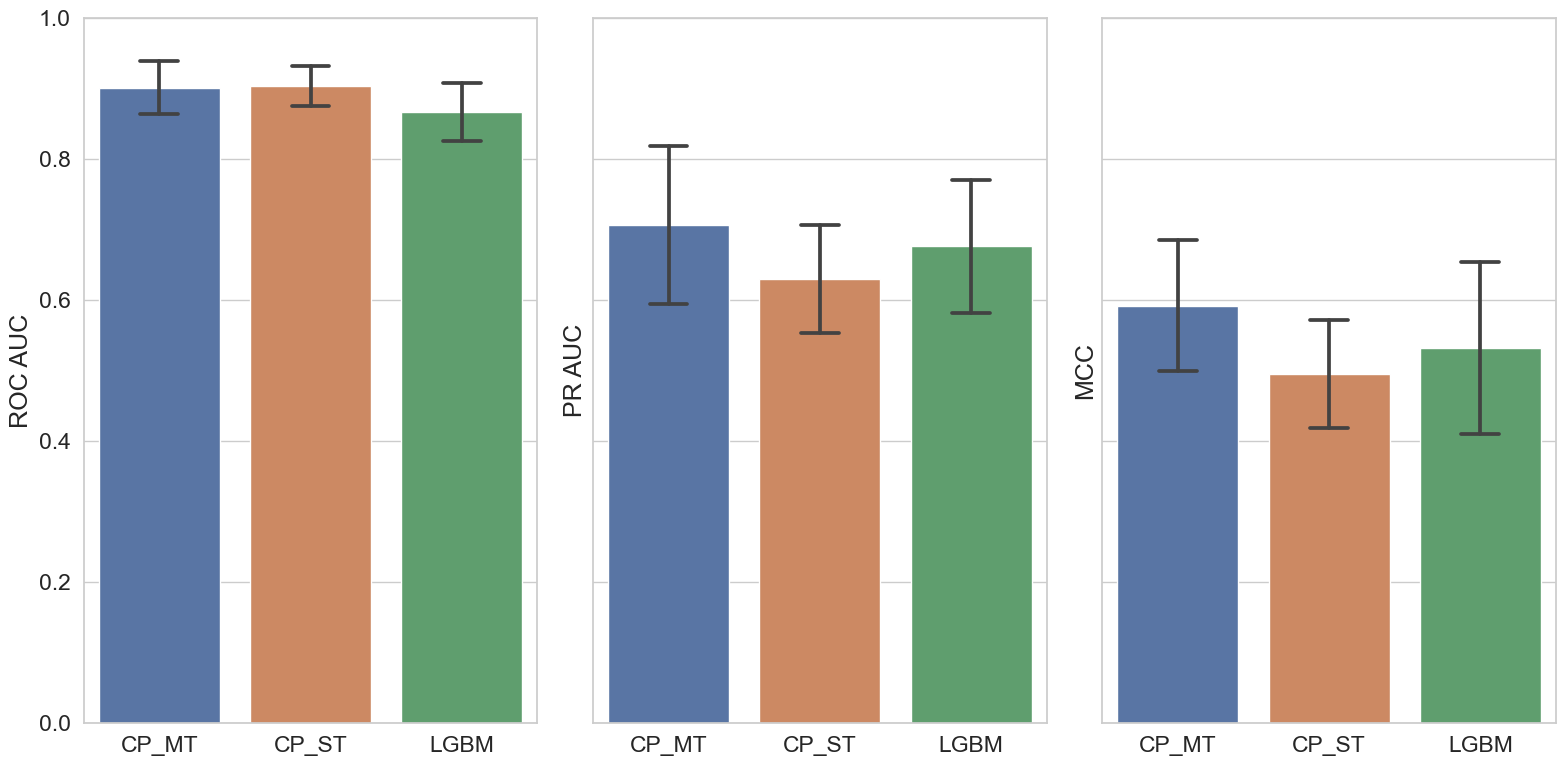

In [13]:
make_barplots(df_random_split, show_errorbars=True)

### 4. Comparing Distributions Across Cross-Validation Folds
Show boxplots with the distributions for the ROC AUC, PR AUC, and MCC over 10 folds of cross validation.  Above the plot show the p-value from Friedman's test.  Note that the only metric with p < 0.05 is ROC AUC. If you prefer violin plots, it's trivial to change the **make_boxplots** function. 

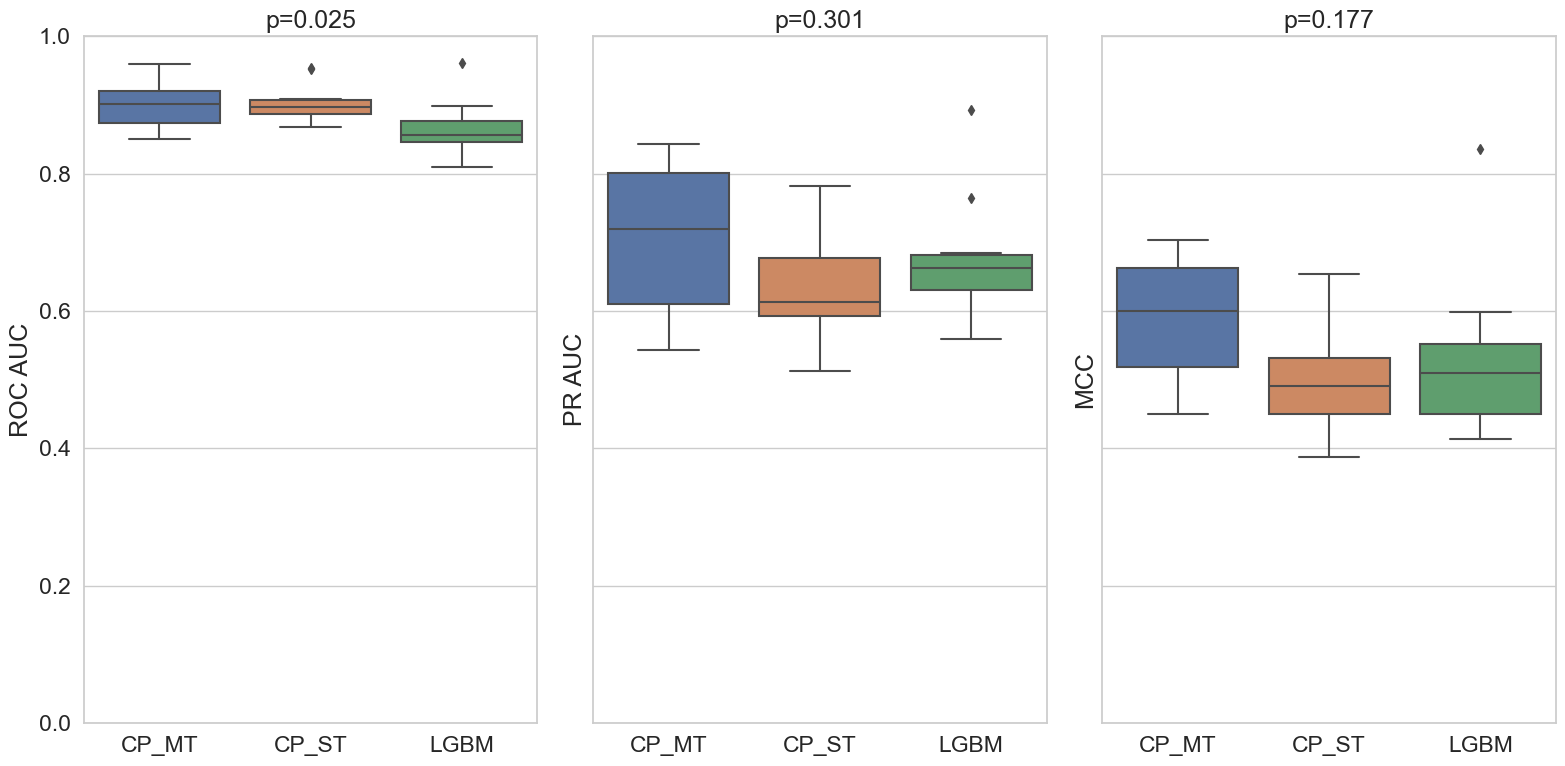

In [25]:
make_boxplots(df_random_split)

### 5. Perform a Post-Hoc Analysis to Examine Differences Between Methods
Friedman's test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at inidividual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use the [Holm Bonferroni Method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#:~:text=In%20statistics%2C%20the%20Holm%E2%80%93Bonferroni,powerful%20than%20the%20Bonferroni%20correction).  The smallest p-value (0.08) is for the comparisons between LGBM and the two ChemProp methods. 

In [9]:
for stat in ["roc_auc", "pr_auc", "mcc"]:
    pc = sp.posthoc_conover_friedman(df_random_split, y_col=stat, group_col="method", block_col="cv_cycle",
                                     p_adjust="holm", melted=True)
    print(stat.upper().replace("_", " "))
    print(pc)
    print()

ROC AUC
          CP_MT     CP_ST      LGBM
CP_MT  1.000000  0.825581  0.076499
CP_ST  0.825581  1.000000  0.072761
LGBM   0.076499  0.072761  1.000000

PR AUC
          CP_MT     CP_ST      LGBM
CP_MT  1.000000  0.589183  1.000000
CP_ST  0.589183  1.000000  0.589183
LGBM   1.000000  0.589183  1.000000

MCC
          CP_MT     CP_ST      LGBM
CP_MT  1.000000  0.234216  0.725131
CP_ST  0.234216  1.000000  0.725131
LGBM   0.725131  0.725131  1.000000



### 6. Plot the Results of the Post-Hoc Analysis
### 6.1 Sign Plots
The tables above have a lot of numbers.  Fortunately, scikit-posthocs provides a couple of useful plots for visualizing the results of post-hoc tests.  The first is the sign plot.  This shows the matrices above color coded by statistical significance.  Each cell in the plot shows the corrected p-value for one pairwise comparison.  All of the cells below are pink, indicating that **none** of the comparisons is statistically signficant. 

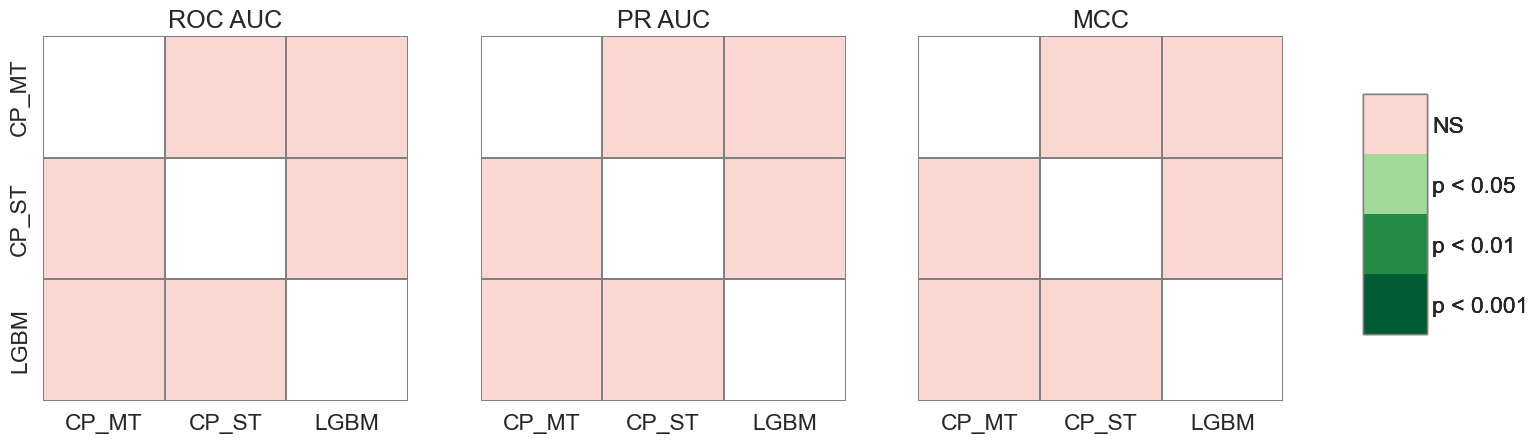

In [10]:
make_sign_plots(df_random_split)

### 6.2 Critical Difference Diagrams

Another interesting visualization provoided by scikit-posthocs is the [critical difference diagram](https://mirkobunse.github.io/CriticalDifferenceDiagrams.jl/dev/#Reading-a-CD-diagram) (CDD).  In this plot, the methods are ordered by their average ranks.  If two methods are connected by a horizontal line, there is **not** a statistically significant difference between the methods.  One advantage of the CDD over the sign plot is that the CDD aslo shows the ranks of the methods.

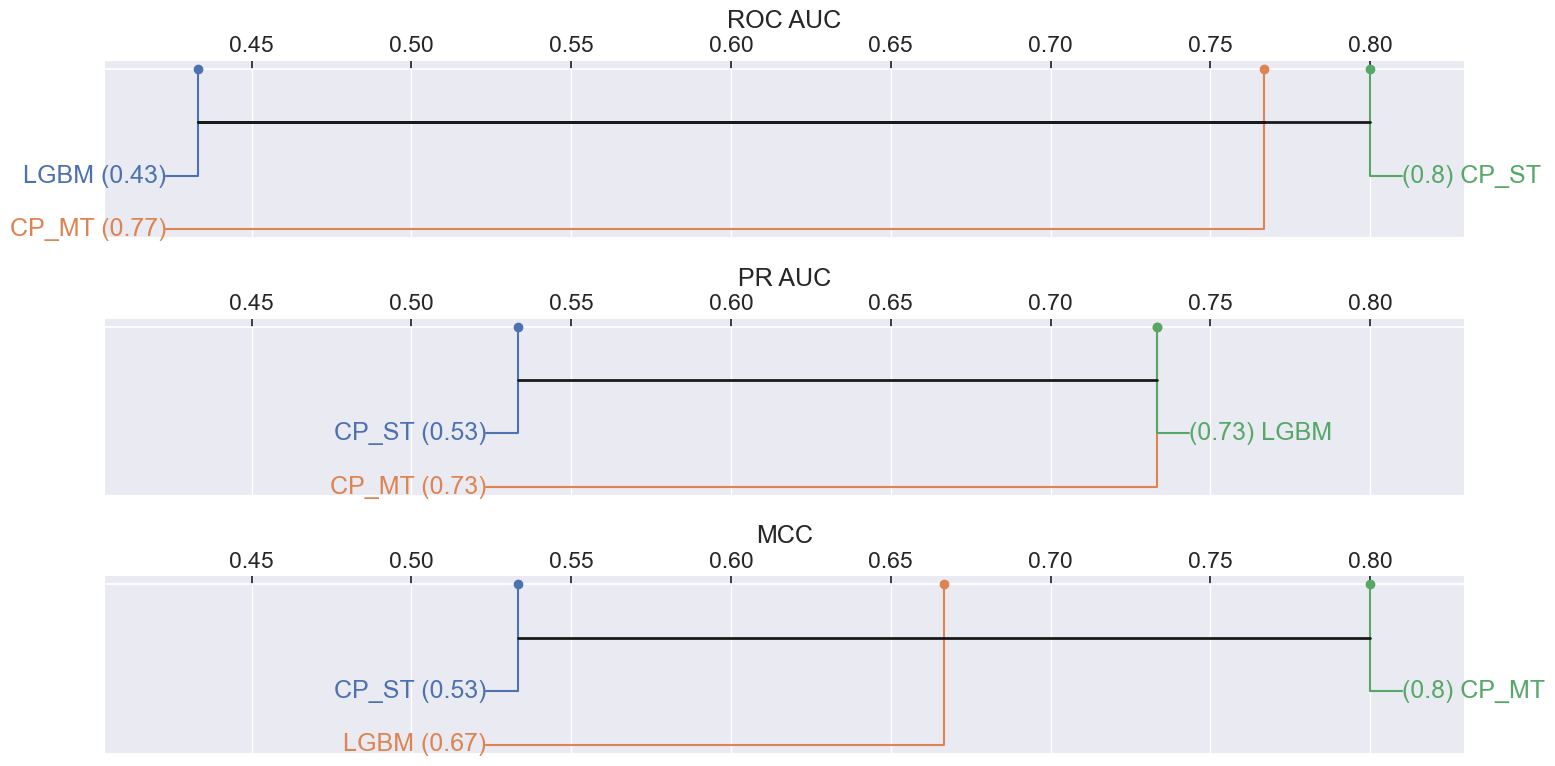

In [11]:
make_critical_difference_diagrams(df_random_split)

### 7. Repeat the Calculations for the Scaffold Splits

When we ran this comparison using random splits, we didn't see a statistically signficant difference between ML methods. Let's try this again with the scaffold splits.  We'll once again start by making boxplots to compare ROC AUC, PR AUC, and MCC for the three approaches.  This time we see that, once again, the only significant comparison is with ROC AUC.  For the scaffold splits, the Friedman's p-value for ROC AUC is 0.007, where it was 0.02 with the random splits.  We might see something in the post-hoc tests this time. 

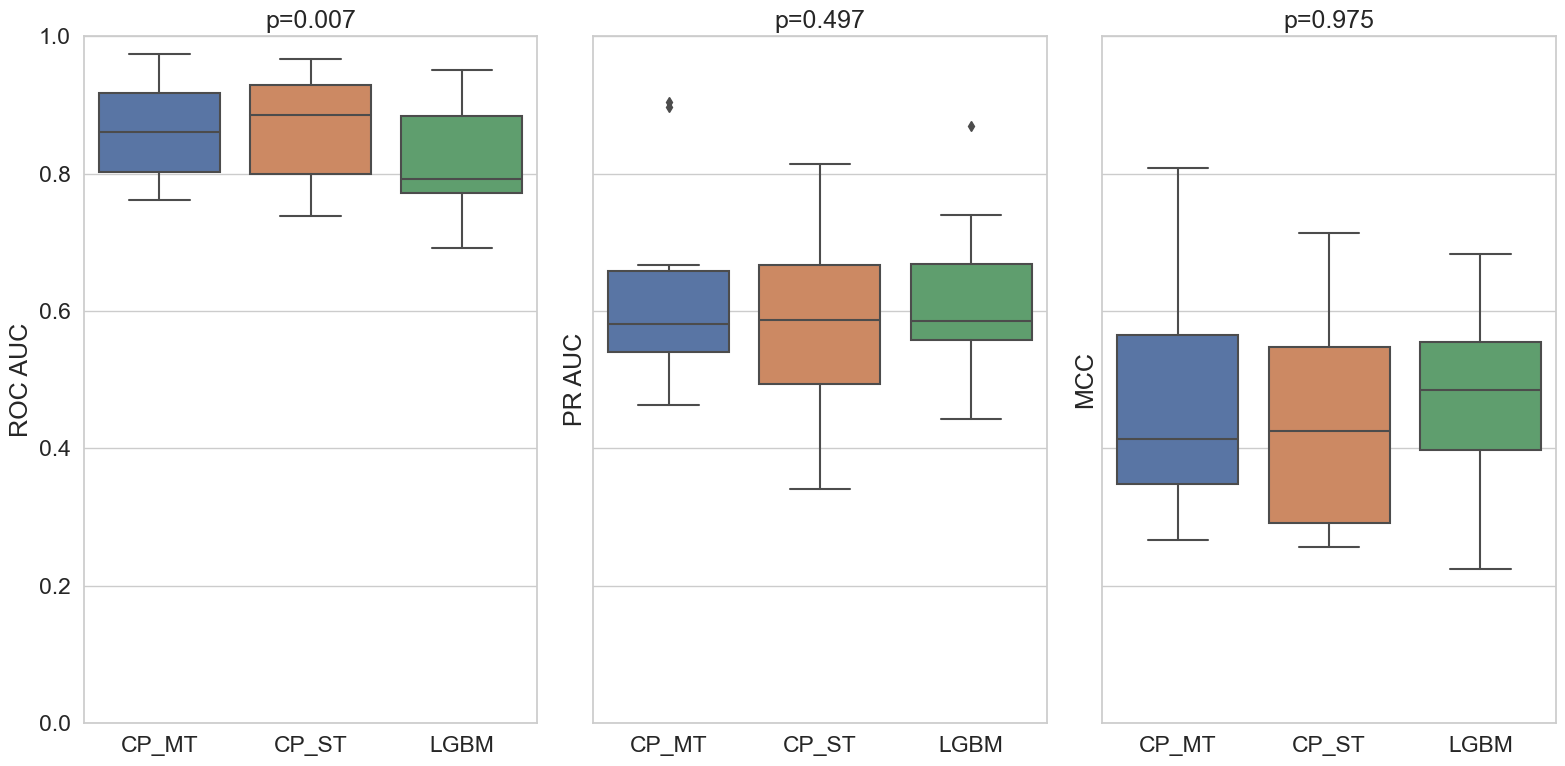

In [26]:
make_boxplots(df_scaffold_split)

We'll use the same procedure we used above to perform the post-hoc tests.  Note that we have significant differences between LGBM and the two ChemProp methods for ROC AUC.

In [13]:
for stat in ["roc_auc", "pr_auc", "mcc"]:
    pc = sp.posthoc_conover_friedman(df_scaffold_split, y_col=stat, group_col="method", block_col="cv_cycle",
                                     p_adjust="holm", melted=True)
    print(stat.upper().replace("_", " "))
    print(pc)
    print()

ROC AUC
          CP_MT     CP_ST      LGBM
CP_MT  1.000000  0.660056  0.028213
CP_ST  0.660056  1.000000  0.048507
LGBM   0.028213  0.048507  1.000000

PR AUC
          CP_MT     CP_ST      LGBM
CP_MT  1.000000  0.834758  0.834758
CP_ST  0.834758  1.000000  0.834758
LGBM   0.834758  0.834758  1.000000

MCC
       CP_MT  CP_ST  LGBM
CP_MT    1.0    1.0   1.0
CP_ST    1.0    1.0   1.0
LGBM     1.0    1.0   1.0



Now we'do the sign plot visualization.  Note that we have green cells for LGBM vs CP_MT and LGBM vs CP_ST.  The green colors indicate that we have a corrected p-value < 0.05. 

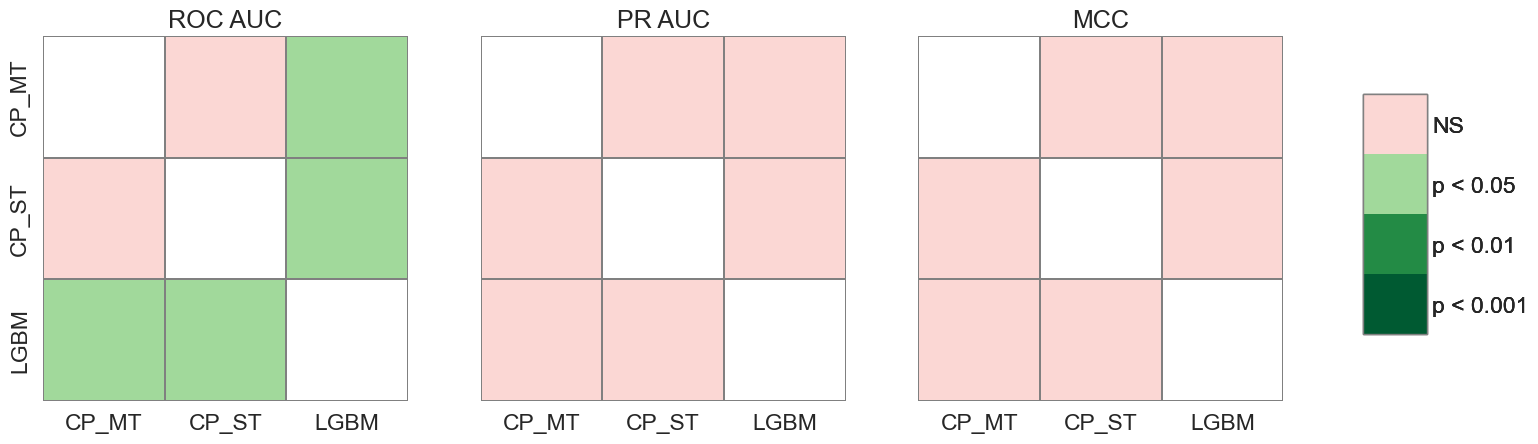

In [14]:
make_sign_plots(df_scaffold_split)

Make the critical difference diagrams.  Note that for ROC AUC, LGBM is not connected to the other two metrics by a horizontal line. This indicates a significant difference between LGBM and the two ChemProp methods.

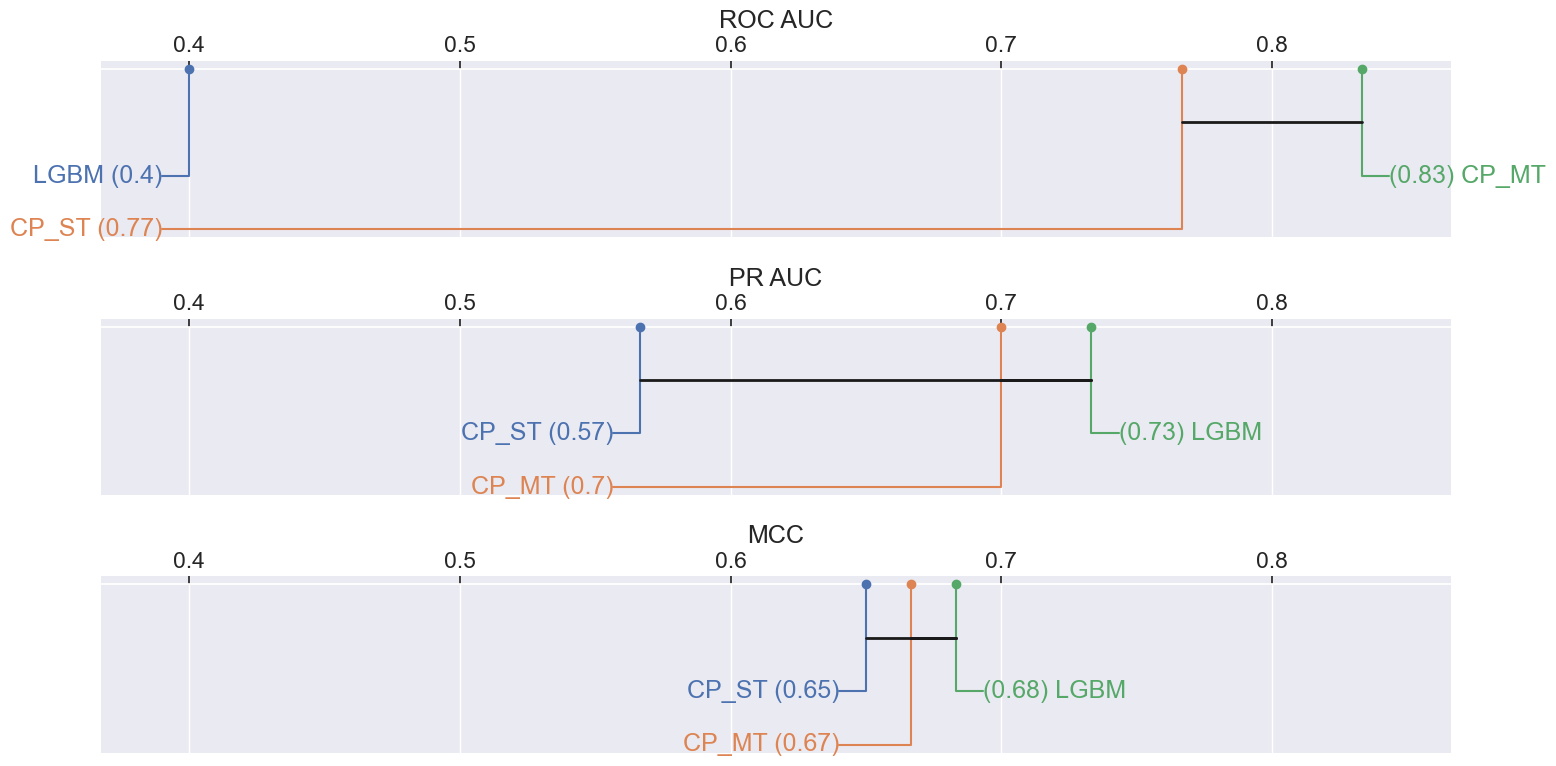

In [15]:
make_critical_difference_diagrams(df_scaffold_split)